In [21]:
import sklearn as sk
import numpy as np
import pandas as pd
import time
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
class CART:    
    def __init__(self, features_rate, min_samples_leaf, max_depth):
        self.features_rate = features_rate
        self.tree_map = {}
        self.min_samples_leaf = min_samples_leaf
        if (max_depth == None):
            self.max_depth = 100000
        else:
            self.max_depth = max_depth

    def gen_tree(self, element_numbers, vertex_num, mean, now_depth, mse_value):
         
        if (now_depth == self.max_depth):  
            self.tree_map[str(vertex_num)] = [[None, None], [1], [mean], [None, None]]
            return 0
        
        min_mse = mse_value

        pos_num_split = np.nan
        value_split = np.nan
        
        left = []
        right = []
        
        cou_elements = len(element_numbers)
        
        best_left_square_sum = np.nan
        best_left_sum = np.nan
        best_right_square_sum = np.nan
        best_right_sum = np.nan
        
        x = self.x[element_numbers]
        y = self.y[element_numbers]

        for feature_num in range(self.features_cou_analize):

            sort_ind = x[:,feature_num].argsort()
            new_x = x[:,feature_num][sort_ind]
            new_y = y[sort_ind]
            
            left_cou = 0
            right_cou = cou_elements
            
            del_num = 0
            right_square_sum = mse_value + mean * mean * cou_elements * 1.0
            right_sum = mean * cou_elements * 1.0
            left_square_sum = 0.0
            left_sum = 0.0
            feature_value_split = np.nan
            for i, feature_value in enumerate(new_x):
                
                if (feature_value_split == feature_value):
                    continue
                    
                if (np.isnan(feature_value_split)):
                    feature_value_split = feature_value
                else:
                    feature_value_split = 0.5 * (feature_value_split + feature_value)
                    
                while (1):
                    if (new_x[del_num] < feature_value_split):
                        y_val = new_y[del_num]
                        del_num += 1
                        left_cou += 1
                        right_cou -= 1
                        
                        left_square_sum += y_val * y_val
                        left_sum += y_val
                        
                        right_square_sum -= y_val * y_val
                        right_sum -= y_val
                    else:
                        break
                
                if (left_cou < self.min_samples_leaf):
                    continue
                elif (right_cou < self.min_samples_leaf):
                    break
                
                now_left_mse = left_square_sum - left_sum * left_sum * 1.0/ left_cou
                now_right_mse = right_square_sum - right_sum * right_sum * 1.0 / right_cou
                
                if (now_left_mse + now_right_mse < min_mse):
                    min_mse = now_left_mse + now_right_mse
                    pos_num_split = feature_num
                    value_split = feature_value_split
                    
                    best_left_square_sum = left_square_sum
                    best_left_sum = left_sum
                    
                    best_right_square_sum = right_square_sum
                    best_right_sum = right_sum
                    
        if (np.isnan(value_split)):
            self.tree_map[str(vertex_num)]= [[None, None], [1], [mean], [None, None]]
            return 0
        
        self.tree_map[str(vertex_num)] = [[self.feature_order[pos_num_split], value_split], [0], [mean], [vertex_num*2 + 1, vertex_num*2 + 2]]
        
        
        left_class = []
        right_class = []
        
        for pos in element_numbers:
            if (self.x[pos][pos_num_split] < value_split):
                left.append(pos)
            else:
                right.append(pos)

        left_mse = best_left_square_sum - (best_left_sum ** 2.0) / len(left)
        right_mse = best_right_square_sum - (best_right_sum ** 2.0) / len(right)
        
        self.feature_contribution[self.feature_order[pos_num_split]] += (mse_value - left_mse - right_mse)
        
        self.gen_tree(left, vertex_num*2 + 1, best_left_sum * 1.0 / len(left), now_depth + 1, left_mse)
        self.gen_tree(right, vertex_num*2 + 2, best_right_sum *1.0/ len(right), now_depth + 1, right_mse)
        
    def fit(self, x, y):
        self.tree_map = {}
        
        x = np.asarray(x, dtype = np.float)
        features_cou = (x.shape)[1]
        self.feature_order = np.sort(np.random.choice((x.shape)[1], int((x.shape)[1] * (self.features_rate)), replace=False))
        
        self.features_cou_analize = int((x.shape)[1] * (self.features_rate))
        self.cou_samples = len(x)
        
        self.feature_contribution = np.zeros(features_cou)
        
        for i in reversed(range(features_cou)):
            if (i not in self.feature_order):
                x = np.delete(x, i, 1)

        self.x = x
        self.y = np.asarray(y, dtype = np.float)
        y_pred = np.tile(np.sum(y) * 1.0 / len(y), len(y))
        
        self.gen_tree(np.arange(self.cou_samples), 0, np.sum(y) * 1.0 / len(y), 0, np.sum((y_pred - self.y) ** 2.0))
        
        return self.tree_map

    def predict(self, data):
        y_pred = []
        for sample in data:
            now_vertex = 0
            while (1):
                if (self.tree_map[str(now_vertex)][1][0] == 1):
                    break
                if (sample[self.tree_map[str(now_vertex)][0][0]] >= self.tree_map[str(now_vertex)][0][1]):
                    now_vertex = self.tree_map[str(now_vertex)][3][1]
                else:
                    now_vertex = self.tree_map[str(now_vertex)][3][0]
            y_pred.append(self.tree_map[str(now_vertex)][2][0])
        return y_pred
        
        

In [3]:
f = open("spam.train.txt", "r")
y_true = []
data = []
for line in f:
    line = line[:len(line) - 1]
    arr = line.split(' ')
    y_true.append(arr[0])
    del arr[0]
    data.append(arr)
x = np.asarray(data, dtype = np.float)
y = np.asarray(y_true, dtype = np.float)

In [4]:
f = open("spam.test.txt", "r")
test_data = []
test_y = []
for line in f:
    line = line[:len(line) - 1]
    arr = line.split(' ')
    test_y.append(arr[0])
    del arr[0]
    test_data.append(arr)
    
test_x = np.asarray(test_data, dtype = np.float)
test_y = np.asarray(test_y, dtype = np.float)

In [5]:
class modify_gb:
    
    def __init__(self, n_estimators, features_rate, cou_samples, min_samples_split, learning_rate, max_depth, loss, regularizator_value):
        self.regularizator_value = regularizator_value
        self.number_elements_in_subsample = cou_samples / n_estimators
        self.n_estimators = n_estimators
        self.features_rate = features_rate
        self.cou_samples = cou_samples
        self.loss = loss
        self.min_samples_split = min_samples_split
        self.shrinkage_value = learning_rate
        if (max_depth == None):
            self.max_depth = 10000
        else:
            self.max_depth = max_depth
    
    def get_predict_for_sample_and_one_tree(self, sample, tree_map):
        now_vertex = 0
        while (1):
            if (tree_map[str(now_vertex)][1][0] == 1):
                break
            if (sample[tree_map[str(now_vertex)][0][0]] >= tree_map[str(now_vertex)][0][1]):
                now_vertex = tree_map[str(now_vertex)][3][1]
            else:
                now_vertex = tree_map[str(now_vertex)][3][0]
        return tree_map[str(now_vertex)][2][0]
    
    def get_predict_for_sample(self, sample):
        answer = 0.0
        for i in range(len(self.trees_list)):
            answer += self.shrinkage_value * self.get_predict_for_sample_and_one_tree(sample, self.trees_list[i][1])
        return answer
    
    def update_grad_for_l2(self, x, tree_map):
        for i, sample in enumerate(x):
            self.now_grad[i] -= 2.0 * self.get_predict_for_sample_and_one_tree(sample, tree_map) * self.shrinkage_value
            
    def update_grad_for_l1(self, x, tree_map):
        for i, sample in enumerate(x):
            pred_for_sample = self.get_predict_for_sample_and_one_tree(sample, tree_map) * self.shrinkage_value
            self.y_balance[i] -= pred_for_sample
            if (self.y_balance[i] == 0.0):
                self.now_grad[i] = 0.00000001
            elif (self.y_balance[i] > 0.0):
                self.now_grad[i] = 1.0
            elif (self.y_balance[i] < 0.0):
                self.now_grad[i] = -1.0
        
        
    def predict_regression(self, x):
        y_pred = np.zeros(len(x))
        for i, sample in enumerate(x):
            y_pred[i] = self.get_predict_for_sample(sample)
        return y_pred
    
    def predict_regression_after_select(self, x):
        x = x[:, self.good_features]
        y_pred = np.zeros(len(x))
        for i, sample in enumerate(x):
            y_pred[i] = self.get_predict_for_sample(sample)
        return y_pred
    
    def fit(self, x, y):
        self.pos_arr = np.arange(self.cou_samples)
        self.now_grad = np.array(y, dtype = np.float)
        self.trees_list = []
        self.y_balance = np.array(y, dtype = np.float)
        
        cart = CART(self.features_rate, self.min_samples_split, self.max_depth)
        
        self.feature_contribution = np.zeros((x.shape)[1])
        
        for i in range(self.n_estimators):
            np.random.shuffle(self.pos_arr)
            index = self.pos_arr[:self.cou_samples / 2]
            now_x = x[index]
            now_y = self.now_grad[index]
            
            cart.fit(now_x, now_y)
            if (i == 0 and self.loss == 'l2'):
                self.now_grad *= 2.0
            elif (i == 0 and self.loss == 'l1'):
                self.now_grad = np.zeros(len(self.now_grad))
                
            self.feature_contribution += cart.feature_contribution
            
            self.trees_list.append([self.shrinkage_value, cart.tree_map])
            
            if (self.loss == 'l2'):
                self.update_grad_for_l2(x, cart.tree_map)
            elif (self.loss == 'l1'):
                self.update_grad_for_l1(x, cart.tree_map)
                
        return self.trees_list
    
    def feature_selection_and_fit(self, x, y):
        print x.shape
        self.fit(x, y)
        old_trees_list = self.trees_list
        old_contrib = self.feature_contribution
        feature_probability = self.feature_contribution / np.sum(self.feature_contribution)
        print feature_probability
        #self.regularizator_value = (sorted(feature_probability))[int(x.shape[1] * 0.2)]
        self.good_features = []
        cou_features = x.shape[1]
        for i in reversed(range(cou_features)):
            if (feature_probability[i] < self.regularizator_value):
                x = np.delete(x, i, axis = 1)
            else:
                self.good_features.append(i)
        self.good_features = sorted(self.good_features)
        self.trees_list = []
        self.fit(x, y)
        
        

# Add noise features and remove them

In [6]:
feature1 = np.random.binomial(10000, 0.9, len(y_true))
feature2 = np.random.binomial(1000, 0.8, len(y_true))
feature3 = np.random.normal(0, 10, len(y_true))
feature4 = np.random.normal(21, 15, len(y_true))
feature5 = np.random.geometric(p=0.1, size=len(y_true))
feature6 = np.random.chisquare(15,len(y_true))
feature7 = np.random.uniform(-10,10,len(y_true))

In [7]:
x = np.insert(x, x.shape[1], feature1, axis = 1)
x = np.insert(x, x.shape[1], feature2, axis = 1)
x = np.insert(x, x.shape[1], feature3, axis = 1)
x = np.insert(x, x.shape[1], feature4, axis = 1)
x = np.insert(x, x.shape[1], feature5, axis = 1)
x= np.insert(x, x.shape[1], feature6, axis = 1)
x = np.insert(x, x.shape[1], feature7, axis = 1)

In [8]:
feature1 = np.random.binomial(10000, 0.9, len(test_y))
feature2 = np.random.binomial(1000, 0.8, len(test_y))
feature3 = np.random.normal(0, 10, len(test_y))
feature4 = np.random.normal(21, 15, len(test_y))
feature5 = np.random.geometric(p=0.1, size=len(test_y))
feature6 = np.random.chisquare(15,len(test_y))
feature7 = np.random.uniform(-10,10,len(test_y))

In [9]:
test_x = np.insert(test_x, test_x.shape[1], feature1, axis = 1)
test_x = np.insert(test_x, test_x.shape[1], feature2, axis = 1)
test_x = np.insert(test_x, test_x.shape[1], feature3, axis = 1)
test_x = np.insert(test_x, test_x.shape[1], feature4, axis = 1)
test_x = np.insert(test_x, test_x.shape[1], feature5, axis = 1)
test_x = np.insert(test_x, test_x.shape[1], feature6, axis = 1)
test_x = np.insert(test_x, test_x.shape[1], feature7, axis = 1)

In [10]:
params = {'n_estimators': 100, 'features_rate': 1.0, 'cou_samples': len(data), 'min_samples_split': 10,
                    'learning_rate' : 0.03, 'max_depth' : 4, 'loss' : 'l2', 'regularizator_value' : 0.0008}
clf_without_select = modify_gb(**params)
clf_with_select = modify_gb(**params)

In [11]:
clf_with_select.feature_selection_and_fit(x, y)
y_pred = clf_with_select.predict_regression_after_select(test_x)
print sk.metrics.mean_squared_error(y_pred, test_y)
print clf_with_select.feature_contribution
print clf_with_select.good_features

(7093, 109)
[  6.40058112e-04   2.97237875e-04   6.17154341e-04   1.67355370e-03
   2.32327605e-02   1.40927175e-03   3.06870810e-03   4.40766503e-04
   2.99764420e-02   3.78382912e-02   3.79763339e-02   4.00784256e-03
   3.03782891e-03   3.45312017e-03   1.15385515e-02   1.23393836e-02
   2.35350744e-02   2.35920573e-02   1.51186268e-03   2.90979334e-03
   1.91159272e-03   6.63684356e-04   1.89067040e-03   8.77411142e-04
   1.75919682e-03   3.44409863e-04   9.20213249e-04   6.10890668e-04
   1.08310442e-03   6.51499105e-03   1.58615379e-03   7.78656366e-03
   6.12712060e-03   4.56051610e-03   0.00000000e+00   2.72741632e-02
   9.09753613e-05   3.12898249e-03   7.23020827e-03   1.36462154e-03
   5.11795785e-04   1.31400022e-02   4.91929552e-04   6.25580443e-03
   3.64579304e-05   2.79846844e-04   8.63338273e-04   5.45328937e-03
   3.13009987e-01   2.44096409e-02   1.41217841e-03   2.89374392e-03
   1.03701534e-02   2.94152809e-02   1.03199285e-03   2.21992976e-03
   2.41599829e-02   0.

In [12]:
clf_without_select.fit(x, y)
y_pred = clf_without_select.predict_regression(test_x)
print sk.metrics.mean_squared_error(y_pred, test_y)
print clf_without_select.feature_contribution

0.0659536577396
[  1.33834380e+01   1.74518572e+01   8.45495410e+00   4.15463415e+01
   7.00860450e+02   5.90964148e+01   6.28780343e+01   9.21775643e+00
   9.31657215e+02   8.69705396e+02   1.08714901e+03   1.59880212e+02
   8.29780438e+01   1.13266821e+02   2.61762842e+02   4.24994520e+02
   6.79385216e+02   7.05613168e+02   2.87277974e+01   5.71683573e+01
   3.25725512e+01   1.22308236e+01   2.48334469e+01   3.73824897e+01
   5.34587804e+01   1.56469932e+01   3.83902958e+00   2.15181063e+01
   9.54630667e+00   2.53237991e+02   7.23120878e+01   1.52865259e+02
   3.17523955e+02   7.20587082e+01   0.00000000e+00   8.32734796e+02
   3.94818545e+00   9.05906029e+01   2.28506208e+02   1.35214681e+01
   8.43782555e+00   4.37433738e+02   6.79138640e+01   8.95983814e+01
   4.24517631e+00   1.56756382e+01   3.04817165e+00   1.40797682e+02
   8.42440143e+03   1.16053184e+03   1.12778831e+02   5.42175302e+01
   2.49278915e+02   7.72306229e+02   6.24464129e+01   8.86121034e+01
   4.88913494e+02 

In [13]:
print test_x.shape

(10056, 109)


TypeError: __init__() got multiple values for keyword argument 'handles'

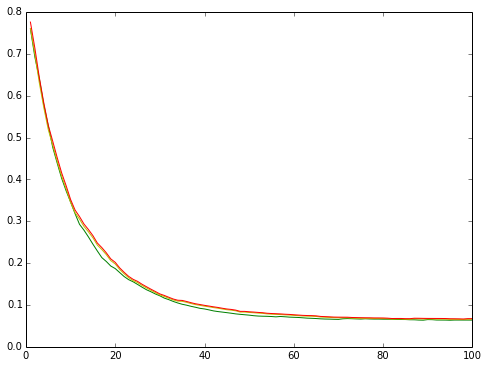

In [22]:
y = test_y.copy()
y1 = test_y.copy()
estimators_list = np.linspace(1, 100, 100)
mse_select = []
mse_without_select = []
cou_samples = len(test_y)
clf_with_select.good_features = sorted(clf_with_select.good_features)
select_x = test_x[:, clf_with_select.good_features]
y = np.array(y, dtype = np.float)
y1 = np.array(y1, dtype = np.float)
for i in range(0, 100):
    for j, sample in enumerate(select_x):
        y[j] -= clf_with_select.get_predict_for_sample_and_one_tree(sample, clf_with_select.trees_list[i][1]) * clf_with_select.shrinkage_value
    for j, sample in enumerate(test_x):
        y1[j] -= clf_without_select.get_predict_for_sample_and_one_tree(sample, clf_without_select.trees_list[i][1]) * clf_without_select.shrinkage_value
    if (i + 1 in estimators_list):
        mse_select.append(np.sum(y ** 2.0) * 1.0 / cou_samples)
        mse_without_select.append(np.sum(y1 ** 2.0) * 1.0 / cou_samples)
    
        
estimators_list = np.asarray(estimators_list, dtype = np.float)
plt.figure(figsize = (8, 6), dpi = 80)
mse_select =np.asarray(mse_select, dtype = np.float)
mse_without_select = np.asarray(mse_without_select, dtype = np.float)
select, = plt.plot(estimators_list, mse_select, c = 'g', label = "select line")
without_select, = plt.plot(estimators_list, mse_without_select, c = 'y', label = "without select")
without_select_bound, = plt.plot(estimators_list, mse_without_select * 1.02, c = 'r', label = "without select bound")
plt.legend(handles = [select, without_select, without_select_bound])
plt.xlabel('cou_estimators')
plt.ylabel('mse')
plt.show()